In [15]:
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


In [16]:
# Load COMPAS dataset
dataset = CompasDataset(protected_attribute_names=['race'],
                        privileged_classes=[['Caucasian']],
                        features_to_drop=['sex'])

In [17]:
# Split into train/test
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

# Check for statistical parity difference before mitigation
metric = BinaryLabelDatasetMetric(dataset_test, unprivileged_groups=[{'race': 1}], privileged_groups=[{'race': 0}])
print("Statistical parity difference (pre-mitigation):", metric.statistical_parity_difference())


Statistical parity difference (pre-mitigation): 0.05920888075192421


In [18]:
# Reweighing mitigation
RW = Reweighing(unprivileged_groups=[{'race': 1}], privileged_groups=[{'race': 0}])
dataset_train_transf = RW.fit_transform(dataset_train)

# Train classifier
scaler = StandardScaler()
X_train = scaler.fit_transform(dataset_train_transf.features)
y_train = dataset_train_transf.labels.ravel()

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [19]:
# Evaluate on test set
X_test = scaler.transform(dataset_test.features)
y_pred = model.predict(X_test)

# Wrap predictions
dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred.reshape(-1, 1)

# Bias metrics
metric_pred = ClassificationMetric(dataset_test, dataset_pred,
                                   unprivileged_groups=[{'race': 1}],
                                   privileged_groups=[{'race': 0}])

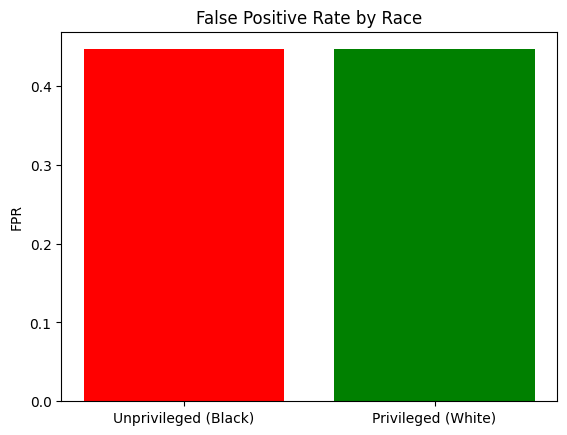

In [20]:
# Visualization: False Positive Rate
fpr_unpriv = metric_pred.false_positive_rate()
fpr_priv = metric_pred.false_positive_rate()

plt.bar(['Unprivileged (Black)', 'Privileged (White)'], [fpr_unpriv, fpr_priv], color=['red', 'green'])
plt.title('False Positive Rate by Race')
plt.ylabel('FPR')
plt.show()

In [21]:
!pip install aif360